# Neural Style Transfer
By Qing Mu, Wen Sun

## Introduction
In this tutorial, we will cover the techniques and algorithm to use a content image and a style image to generate a stylized image.

The main idea of our project is to extract features from certain layers of VGG-19 to generate the target image. To get result of higher perceptual quality, we choose relu4_2 and relu5_2 to extract content while using relu1_1, relu2_1, relu3_1, relu4_1 and relu5_1 to extract texture from the style image. 

The cost function is defined over the output of content layers and style layers. Afterwards, we use Adam algorithm to optimize the network and use back-propagation to generate the target image.

Since the algorithm define the style of an image as texture, to get an amazing result, you may want to choose a style image with special textures such as Starry Night.

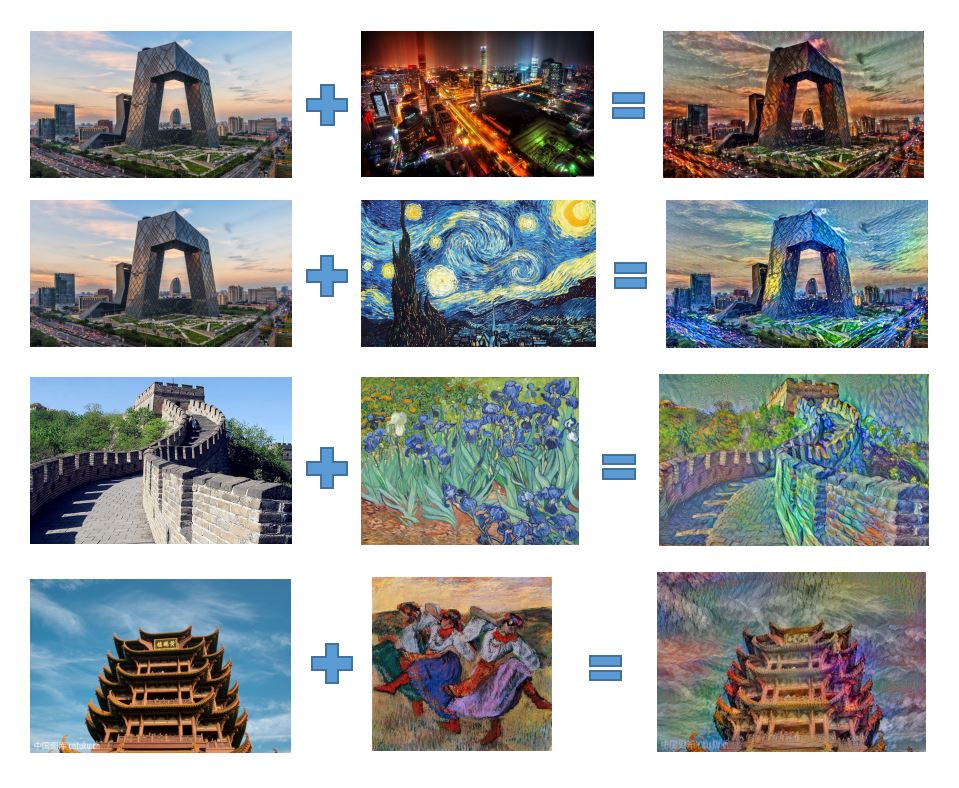

## Running Dependencies
To run this program, you first need to install required libraries,including
* TensorFlow
* NumPy
* SciPy
* Pillow

## Data File
[Pre-trained VGG network](http://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat) (MD5 8ee3263992981a1d26e73b3ca028a123) - put it in the top level of this repository.

### Import

In [1]:
import os

import numpy as np
import scipy.misc
import tensorflow as tf

import math
from argparse import ArgumentParser

from PIL import Image
from sys import stderr
import scipy.io
from functools import reduce

### Default Arguments

In [19]:
#HyperParameters
CONTENT_WEIGHT = 5e0 # content and style ratio
CONTENT_WEIGHT_BLEND = 1
STYLE_WEIGHT = 5e2
TV_WEIGHT = 1e2
STYLE_LAYER_WEIGHT_EXP = 1

#Optimize Parameters
LEARNING_RATE = 1e1
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1e-08

STYLE_SCALE = 1
ITERATIONS = 1000
VGG_PATH = './imagenet-vgg-verydeep-19.mat'
STYLE_PATH = './style.jpg'
CONTENT_PATH = './content.jpg'
OUTPUT = './result.jpg'
POOLING = 'max'
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4

#Other Setting
PRESERVE_COLORS = False


###  Define VGG-19 Network Layers
In this tutorial, we will be using VGG-19 pre-trained trough ImageNet. ImageNet is a large visual database covering over 14 million URLs of images and more than 20 thousand ambiguous categories which helps to cover more diverse feature when it comes to natural images.

In generating process, we use 'relu4_2', 'relu5_2' of VGG-19 to extract feature map from content image and 'relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1' to extract feature map from style images.

In [3]:
VGG19_LAYERS = (
    'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

    'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

    'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
    'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

    'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
    'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

    'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
    'relu5_3', 'conv5_4', 'relu5_4'
)

### Declare from which layers of the network we extract the feature maps

In [4]:
CONTENT_LAYERS = ('relu4_2', 'relu5_2')
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

### Check network path
We are using the pretrained VGG-19 network weights .mat file.

In [5]:
 if not os.path.isfile(VGG_PATH):
        print("Network %s does not exist. (Did you forget to download it?)" % VGG_PATH)

### Load in VGG-19 and set up the network
After we load the input images, we need to do a normalization to the images. The method is to compute the mean_pixel, which is the average pixel value of each pixel, and deduct this value from all the original pixels.

In [6]:
def load_net(data_path):
    data = scipy.io.loadmat(data_path)
    if not all(i in data for i in ('layers', 'classes', 'normalization')):
        raise ValueError("You're using the wrong VGG19 data. Please follow the instructions in the README to download the correct data.")
    mean = data['normalization'][0][0][0]
    mean_pixel = np.mean(mean, axis=(0, 1))
    weights = data['layers'][0]
    return weights, mean_pixel

def preprocess(image, mean_pixel):
    return image - mean_pixel

def unprocess(image, mean_pixel):
    return image + mean_pixel

Here we define the methods to establish the network layers according to the layer type.

In [6]:
def net_preloaded(weights, input_image, pooling):
    net = {}
    current = input_image
    for i, name in enumerate(VGG19_LAYERS):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
            kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            current = _conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = _pool_layer(current, pooling)
        net[name] = current

    assert len(net) == len(VGG19_LAYERS)
    return net

def _conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)


def _pool_layer(input, pooling):
    if pooling == 'avg':
        return tf.nn.avg_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
                padding='SAME')
    else:
        return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
                padding='SAME')

### Define stylize process
#### Step 1 Content representation
Extract feature map from content image p and a random generated image x through VGG-19 and try to minimize the difference. The loss function over layer l is defined as follow. Here we are evaluating the difference of value of position j in ith kernal of layer l.
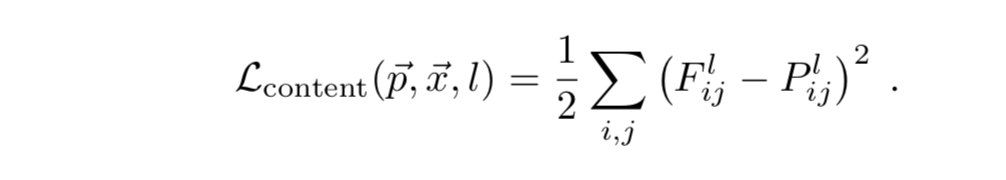
#### Step 2 Style representation
To extract the texture of style, we will evaluate the correlation between two patterns and to transform it. Here we use dot product of filter i and filter j to represent the correlation between pattern i and pattern j for .
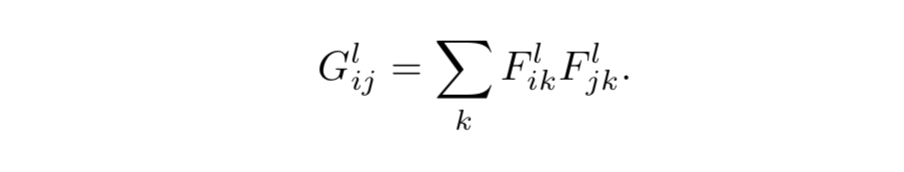
Then we calculate the difference of style representation between content image A and generated image G in layer l:
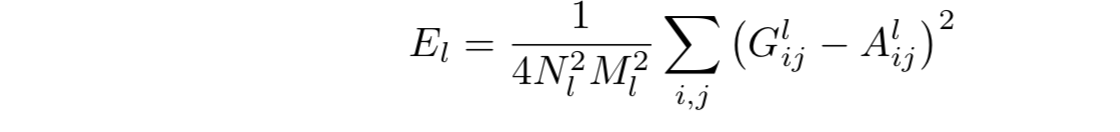
And the total style loss:
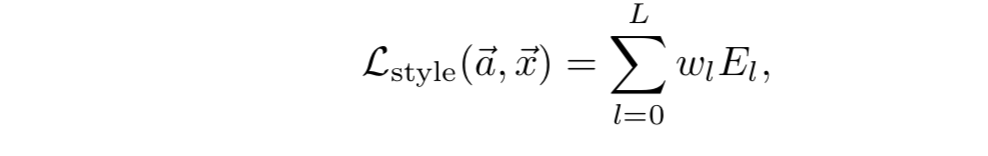
#### Step 3 Style transfer
We define the total loss as follow and we are going to use Adam algorithm to optimize the result.
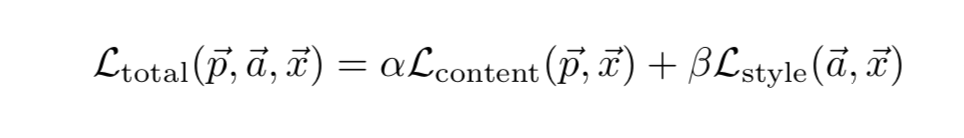

In [7]:
def stylize(network, initial, initial_noiseblend, content, styles, preserve_colors, iterations,
        content_weight, content_weight_blend, style_weight, style_layer_weight_exp, style_blend_weights, tv_weight,
        learning_rate, beta1, beta2, epsilon, pooling,
        print_iterations=None, checkpoint_iterations=None):
    """
    Stylize images.

    This function yields tuples (iteration, image); `iteration` is None
    if this is the final image (the last iteration).  Other tuples are yielded
    every `checkpoint_iterations` iterations.

    :rtype: iterator[tuple[int|None,image]]
    """
    shape = (1,) + content.shape
    style_shapes = [(1,) + style.shape for style in styles]
    content_features = {}
    style_features = [{} for _ in styles]

    vgg_weights, vgg_mean_pixel = load_net(network)

    layer_weight = 1.0
    style_layers_weights = {}
    for style_layer in STYLE_LAYERS:
        style_layers_weights[style_layer] = layer_weight
        layer_weight *= style_layer_weight_exp

    # normalize style layer weights
    layer_weights_sum = 0
    for style_layer in STYLE_LAYERS:
        layer_weights_sum += style_layers_weights[style_layer]
    for style_layer in STYLE_LAYERS:
        style_layers_weights[style_layer] /= layer_weights_sum

    # compute content features in feedforward mode
    g = tf.Graph()
    with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
        image = tf.placeholder('float', shape=shape)
        net = net_preloaded(vgg_weights, image, pooling)
        content_pre = np.array([preprocess(content, vgg_mean_pixel)])
        for layer in CONTENT_LAYERS:
            content_features[layer] = net[layer].eval(feed_dict={image: content_pre})

    # compute style features in feedforward mode
    for i in range(len(styles)):
        g = tf.Graph()
        with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
            image = tf.placeholder('float', shape=style_shapes[i])
            net = net_preloaded(vgg_weights, image, pooling)
            style_pre = np.array([preprocess(styles[i], vgg_mean_pixel)])
            for layer in STYLE_LAYERS:
                features = net[layer].eval(feed_dict={image: style_pre})
                features = np.reshape(features, (-1, features.shape[3]))
                gram = np.matmul(features.T, features) / features.size
                style_features[i][layer] = gram

    initial_content_noise_coeff = 1.0 - initial_noiseblend

    # make stylized image using backpropogation
    with tf.Graph().as_default():
        if initial is None:
            noise = np.random.normal(size=shape, scale=np.std(content) * 0.1)
            initial = tf.random_normal(shape) * 0.256
        else:
            initial = np.array([preprocess(initial, vgg_mean_pixel)])
            initial = initial.astype('float32')
            noise = np.random.normal(size=shape, scale=np.std(content) * 0.1)
            initial = (initial) * initial_content_noise_coeff + (tf.random_normal(shape) * 0.256) * (1.0 - initial_content_noise_coeff)
        image = tf.Variable(initial)
        net = net_preloaded(vgg_weights, image, pooling)

        # compute content loss
        content_layers_weights = {}
        content_layers_weights['relu4_2'] = content_weight_blend
        content_layers_weights['relu5_2'] = 1.0 - content_weight_blend

        content_loss = 0
        content_losses = []
        for content_layer in CONTENT_LAYERS:
            content_losses.append(content_layers_weights[content_layer] * content_weight * (2 * tf.nn.l2_loss(
                    net[content_layer] - content_features[content_layer]) /
                    content_features[content_layer].size))
        content_loss += reduce(tf.add, content_losses)

        # style loss
        style_loss = 0
        for i in range(len(styles)):
            style_losses = []
            for style_layer in STYLE_LAYERS:
                layer = net[style_layer]
                _, height, width, number = map(lambda i: i.value, layer.get_shape())#
                size = height * width * number
                feats = tf.reshape(layer, (-1, number))
                gram = tf.matmul(tf.transpose(feats), feats) / size
                style_gram = style_features[i][style_layer]
                style_losses.append(style_layers_weights[style_layer] * 2 * tf.nn.l2_loss(gram - style_gram) / style_gram.size)
            style_loss += style_weight * style_blend_weights[i] * reduce(tf.add, style_losses)

        
        ####
        # overall loss
        loss = content_loss + style_loss #+ tv_loss

        # optimizer setup, add it to the graph and return an tf.Operation
        train_step = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon).minimize(loss)

        def print_progress():
            stderr.write('  content loss: %g\n' % content_loss.eval())
            stderr.write('    style loss: %g\n' % style_loss.eval())
            stderr.write('    total loss: %g\n' % loss.eval())

        # optimization
        best_loss = float('inf')
        best = None
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            stderr.write('Optimization started...\n')
            if (print_iterations and print_iterations != 0):
                print_progress()
            for i in range(iterations):
                stderr.write('Iteration %4d/%4d\n' % (i + 1, iterations))
                train_step.run()

                last_step = (i == iterations - 1)
                if last_step or (print_iterations and i % print_iterations == 0):
                    print_progress()

                if (checkpoint_iterations and i % checkpoint_iterations == 0) or last_step:
                    this_loss = loss.eval()
                    if this_loss < best_loss:
                        best_loss = this_loss
                        best = image.eval()

                    img_out = unprocess(best.reshape(shape[1:]), vgg_mean_pixel)

                    if preserve_colors and preserve_colors == True:
                        original_image = np.clip(content, 0, 255)
                        styled_image = np.clip(img_out, 0, 255)

                        # Luminosity transfer steps:
                        # 1. Convert stylized RGB->grayscale accoriding to Rec.601 luma (0.299, 0.587, 0.114)
                        # 2. Convert stylized grayscale into YUV (YCbCr)
                        # 3. Convert original image into YUV (YCbCr)
                        # 4. Recombine (stylizedYUV.Y, originalYUV.U, originalYUV.V)
                        # 5. Convert recombined image from YUV back to RGB

                        # 1
                        styled_grayscale = rgb2gray(styled_image)
                        styled_grayscale_rgb = gray2rgb(styled_grayscale)

                        # 2
                        styled_grayscale_yuv = np.array(Image.fromarray(styled_grayscale_rgb.astype(np.uint8)).convert('YCbCr'))

                        # 3
                        original_yuv = np.array(Image.fromarray(original_image.astype(np.uint8)).convert('YCbCr'))

                        # 4
                        w, h, _ = original_image.shape
                        combined_yuv = np.empty((w, h, 3), dtype=np.uint8)
                        combined_yuv[..., 0] = styled_grayscale_yuv[..., 0]
                        combined_yuv[..., 1] = original_yuv[..., 1]
                        combined_yuv[..., 2] = original_yuv[..., 2]

                        # 5
                        img_out = np.array(Image.fromarray(combined_yuv, 'YCbCr').convert('RGB'))


                    yield (
                        (None if last_step else i),
                        img_out
                    )


def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)

#These two methods are used when we want to preserve the color of content image.
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def gray2rgb(gray):
    w, h = gray.shape
    rgb = np.empty((w, h, 3), dtype=np.float32)
    rgb[:, :, 2] = rgb[:, :, 1] = rgb[:, :, 0] = gray
    return rgb

### Define methods to read input images and save result.

In [8]:
def imread(path):
    #read an image from a file as an array
    img = scipy.misc.imread(path).astype(np.float)
    if len(img.shape) == 2:
        # grayscale
        img = np.dstack((img,img,img))
    elif img.shape[2] == 4:
        # PNG with alpha channel
        img = img[:,:,:3]
    return img

def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    Image.fromarray(img).save(path, quality=95)

#if __name__ == '__main__':
   # main()

### Ready to transfer

Read in style image and content image. Here we define 1000 iterations to call the stylize functions to optimize the generatede image.

In [9]:
import imageio
from skimage import transform

### Initialize parameters

In [10]:
content_image = imageio.imread(CONTENT_PATH)
style_images = [imageio.imread(STYLE_PATH)]

In [11]:
target_shape = content_image.shape

In [12]:
    #Adjust the size and shape of style image to fit the output shape
    for i in range(len(style_images)):
        style_scale = STYLE_SCALE
        style_images[i] = scipy.misc.imresize(style_images[i], style_scale *
                target_shape[1] / style_images[i].shape[1])

    #In default, for every style image, the style weight is the same. But we can set the weights of different style images
    style_blend_weights = [1.0/len(style_images) for _ in style_images]

In [14]:
#In default, for every style image, the style weight is the same. 
initial_noiseblend = 1.0
initial = content_image

### Optimization
For each iteration, call the stylize method and optimize the result. In default, the iteration number is 1000.

In [16]:
for iteration, image in stylize(
        network =VGG_PATH,
        initial=initial,
        initial_noiseblend=initial_noiseblend,
        content=content_image,
        styles=style_images,
        preserve_colors=PRESERVE_COLORS,
        iterations=ITERATIONS,
        content_weight=CONTENT_WEIGHT,
        content_weight_blend=CONTENT_WEIGHT_BLEND,
        style_weight=STYLE_WEIGHT,
        style_layer_weight_exp=STYLE_LAYER_WEIGHT_EXP,
        style_blend_weights=style_blend_weights,
        tv_weight=TV_WEIGHT,
        learning_rate=LEARNING_RATE,
        beta1=BETA1,
        beta2=BETA2,
        epsilon=EPSILON,
        pooling=POOLING,
        print_iterations=None,
        checkpoint_iterations=None
    ):
        output_file = None
        combined_rgb = image
        output_file = OUTPUT
        if output_file:
            imsave(output_file, combined_rgb)

Optimization started...
Iteration    1/1000
Iteration    2/1000
Iteration    3/1000
Iteration    4/1000
Iteration    5/1000
Iteration    6/1000
Iteration    7/1000
Iteration    8/1000
Iteration    9/1000
Iteration   10/1000
Iteration   11/1000
Iteration   12/1000
Iteration   13/1000
Iteration   14/1000
Iteration   15/1000
Iteration   16/1000
Iteration   17/1000
Iteration   18/1000
Iteration   19/1000
Iteration   20/1000
Iteration   21/1000
Iteration   22/1000
Iteration   23/1000
Iteration   24/1000
Iteration   25/1000
Iteration   26/1000
Iteration   27/1000
Iteration   28/1000
Iteration   29/1000
Iteration   30/1000
Iteration   31/1000
Iteration   32/1000
Iteration   33/1000
Iteration   34/1000
Iteration   35/1000
Iteration   36/1000
Iteration   37/1000
Iteration   38/1000
Iteration   39/1000
Iteration   40/1000
Iteration   41/1000
Iteration   42/1000
Iteration   43/1000
Iteration   44/1000
Iteration   45/1000
Iteration   46/1000
Iteration   47/1000
Iteration   48/1000
Iteration   49/1

Iteration  410/1000
Iteration  411/1000
Iteration  412/1000
Iteration  413/1000
Iteration  414/1000
Iteration  415/1000
Iteration  416/1000
Iteration  417/1000
Iteration  418/1000
Iteration  419/1000
Iteration  420/1000
Iteration  421/1000
Iteration  422/1000
Iteration  423/1000
Iteration  424/1000
Iteration  425/1000
Iteration  426/1000
Iteration  427/1000
Iteration  428/1000
Iteration  429/1000
Iteration  430/1000
Iteration  431/1000
Iteration  432/1000
Iteration  433/1000
Iteration  434/1000
Iteration  435/1000
Iteration  436/1000
Iteration  437/1000
Iteration  438/1000
Iteration  439/1000
Iteration  440/1000
Iteration  441/1000
Iteration  442/1000
Iteration  443/1000
Iteration  444/1000
Iteration  445/1000
Iteration  446/1000
Iteration  447/1000
Iteration  448/1000
Iteration  449/1000
Iteration  450/1000
Iteration  451/1000
Iteration  452/1000
Iteration  453/1000
Iteration  454/1000
Iteration  455/1000
Iteration  456/1000
Iteration  457/1000
Iteration  458/1000
Iteration  459/1000


Iteration  820/1000
Iteration  821/1000
Iteration  822/1000
Iteration  823/1000
Iteration  824/1000
Iteration  825/1000
Iteration  826/1000
Iteration  827/1000
Iteration  828/1000
Iteration  829/1000
Iteration  830/1000
Iteration  831/1000
Iteration  832/1000
Iteration  833/1000
Iteration  834/1000
Iteration  835/1000
Iteration  836/1000
Iteration  837/1000
Iteration  838/1000
Iteration  839/1000
Iteration  840/1000
Iteration  841/1000
Iteration  842/1000
Iteration  843/1000
Iteration  844/1000
Iteration  845/1000
Iteration  846/1000
Iteration  847/1000
Iteration  848/1000
Iteration  849/1000
Iteration  850/1000
Iteration  851/1000
Iteration  852/1000
Iteration  853/1000
Iteration  854/1000
Iteration  855/1000
Iteration  856/1000
Iteration  857/1000
Iteration  858/1000
Iteration  859/1000
Iteration  860/1000
Iteration  861/1000
Iteration  862/1000
Iteration  863/1000
Iteration  864/1000
Iteration  865/1000
Iteration  866/1000
Iteration  867/1000
Iteration  868/1000
Iteration  869/1000


### Show the generated result

#### Content image

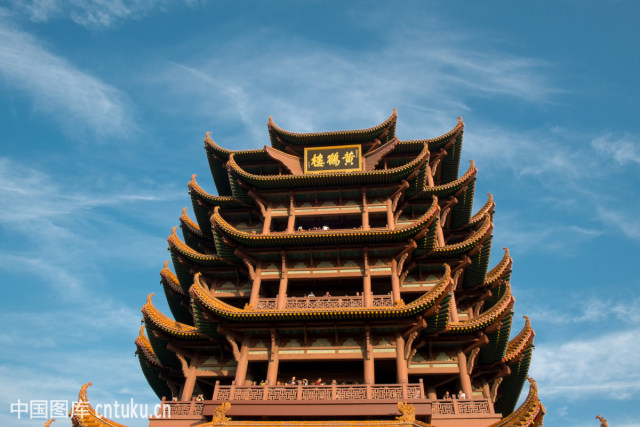

#### Style image

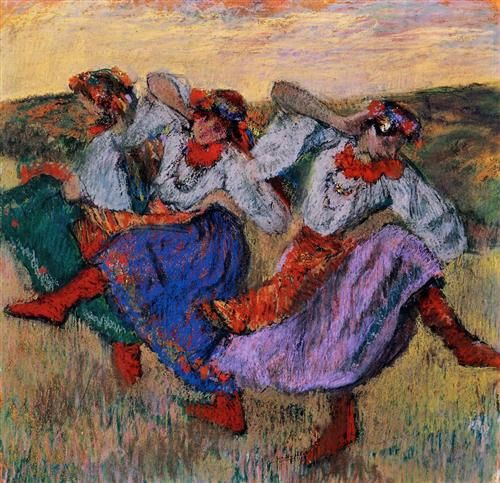

Populating the interactive namespace from numpy and matplotlib


C:\Users\jenni\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread', 'imsave']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


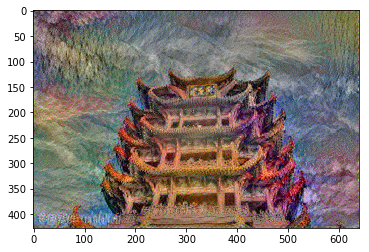

In [18]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('result.jpg')
imgplot = plt.imshow(img)
plt.show()

## Citation

athalye2015neuralstyle,  
author = Anish Athalye,  
title = Neural Style,  
year = 2015,  
[https://github.com/anishathalye/neural-style](https://github.com/anishathalye/neural-style)

## Copyright <2018> <COPYRIGHT Wen Sun and Qing Mu>

Copyright (c) 2018 Wen Sun and Qing Mu. Released under GPLv3. See [license](LICENSE.txt) for details.
